### Tutorial time series analysis - Descomposition & stationarity

In [1]:
import os
import sys
import warnings
from datetime import date
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from numpy.linalg import LinAlgError

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, acf, plot_pacf, pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
import statsmodels.api as sm
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set(style="darkgrid", color_codes=True)

In [4]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

### Download dataset

Load monthly Industrial Production and daily NASDAQ stock market index:

In [5]:
industrial_production = web.DataReader('IPGMFN', 'fred', '1988', '2020-02').squeeze().dropna()
nasdaq = web.DataReader('NASDAQCOM', 'fred', '1990', '2020-03-31').squeeze().dropna()

In [22]:
industrial_production.head()

DATE
1988-01-01    55.8841
1988-02-01    57.0773
1988-03-01    57.7470
1988-04-01    57.9755
1988-05-01    58.0678
Name: IPGMFN, dtype: float64

In [23]:
nasdaq.head()

DATE
1990-01-02    459.33
1990-01-03    460.90
1990-01-04    459.39
1990-01-05    458.22
1990-01-08    458.71
Name: NASDAQCOM, dtype: float64

### Plot time series

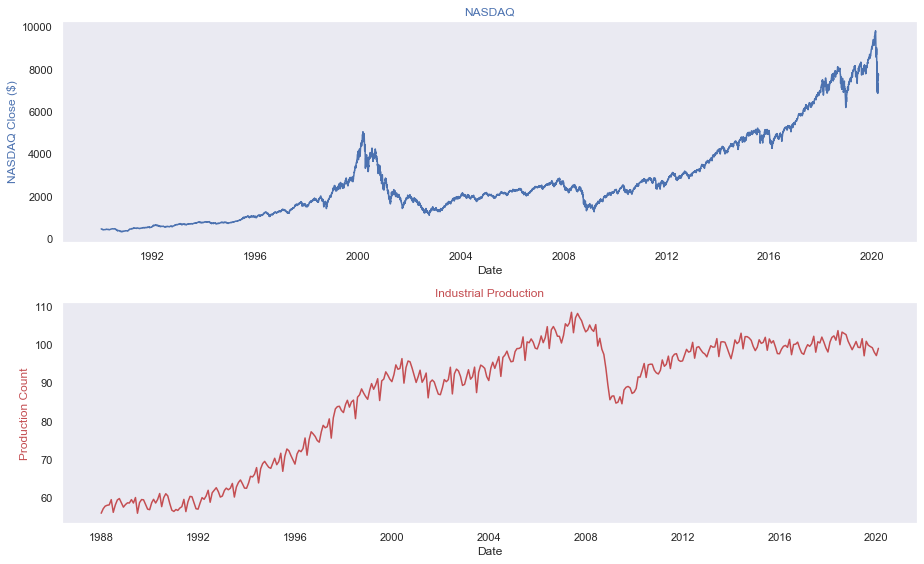

In [8]:
fig, ax = plt.subplots(2,1,figsize=(13, 8))

ax[0].plot(nasdaq, color='b')
ax[1].plot(industrial_production, color='r')

ax[0].set_xlabel('Date')
ax[1].set_xlabel('Date')

ax[0].set_title('NASDAQ', color='b')
ax[1].set_title('Industrial Production', color='r')

ax[0].set_ylabel('NASDAQ Close ($)', color='b')
ax[1].set_ylabel('Production Count', color='r')

ax[0].grid(False)
ax[1].grid(False)

plt.tight_layout()
plt.show()

### Additive Decomposition

Time series data typically contains a mix of various patterns that can be decomposed into several components, each representing an underlying pattern category. In particular, time series often consist of the systematic components *trend, seasonality and cycles, and unsystematic noise(white noise)*. These components can be combined in an additive, linear model, in particular when fluctuations do not depend on the level of the series, or in a non-linear, multiplicative model.

These components can be split up automatically. statsmodels includes a simple method to split the time series into a trend, seasonal, and residual component using moving averages. We can apply it to monthly data on industrial manufacturing production with both a strong trend and seasonality component, as follows:

In [10]:
components = tsa.seasonal_decompose(industrial_production, model='additive')

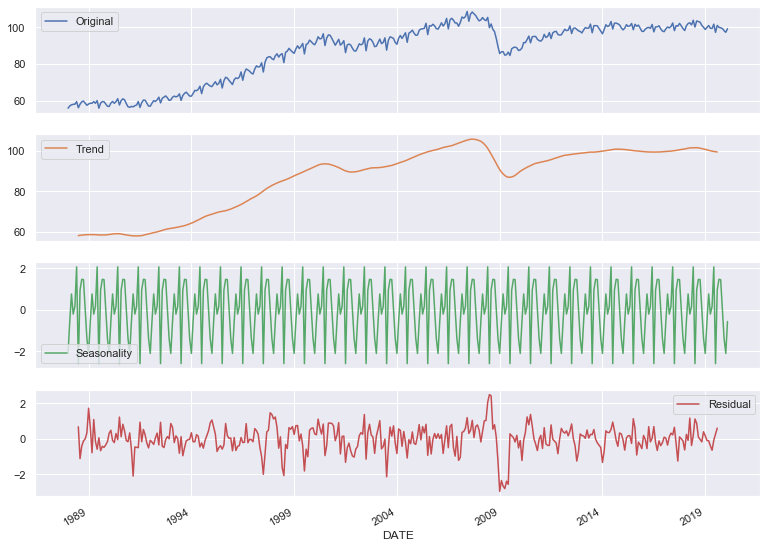

In [11]:
ts = (industrial_production.to_frame('Original')
      .assign(Trend=components.trend)
      .assign(Seasonality=components.seasonal)
      .assign(Residual=components.resid))

ts.plot(subplots=True, figsize=(13, 10))
plt.show()

### Time Series Stationarity

The statistical properties, such as the mean, variance, or autocorrelation, of a stationary time series don't change over time. Hence, stationarity implies that a time series does not have any trend or seasonal effects and that descriptive statistics, such as the mean or the standard deviation, when computed for different rolling windows, remain constant or do not change much over time. It reverts to its mean, and the deviations have constant amplitude, while short-term movements always look fairly similar.

Strict stationarity requires the joint distribution of any subset of time series observations to be independent of time with respect to all moments. So, in addition to the mean and variance, higher moments such as skew and kurtosis, also need to be constant, irrespective of the lag between different observations. In most applications, we limit stationarity to first and second moments so that the time series is covariance stationary with constant mean, variance, and autocorrelation.

Note that we specifically allow for dependence between observations at different lags, just like we want the input data for linear regression to be correlated with the outcome. Stationarity implies that these relationships are stable, which facilitates prediction as the model can focus on learning systematic patterns that take place within stable statistical properties.

To satisfy the stationarity assumption of linear time series models, we need to transform the original time series, often in several steps. Common transformations include:

1- Taking the (natural) logarithm to convert an exponential growth pattern into a linear trend and stabilize the variance.

2- Deflation implies dividing a time series by another series that causes trending behavior, for example dividing a nominal series by a price index to convert it into a real measure.

3- Differencing a time-series meaning for each value in the time-series we subtract its previous value.Alt text that describes the graphic

Other Transformations:

* Take the square root:
  ``np.sqrt(df)``
* Take the proportional change:
  ``df.shift(1)/df``
  
  
**Test for stationarity**

The augmented ``Dicky-Fuller test``
- Tests for trend non-stationarity
- Null hypothesis is time series is non-stationa

In [12]:
adf = adfuller(industrial_production)

print(f'Test Statistic: {adf[0]}')
print(f'\nP-Value: {adf[1]}')
print(f'\nCritical Values: {adf[4]}')

Test Statistic: -1.7712670135504756

P-Value: 0.39481721220385035

Critical Values: {'1%': -3.448196541708585, '5%': -2.869404683789669, '10%': -2.5709597356805545}


* 0th element is test statistic (-1.59)
More negative means more likely to be stationary
* 1st element is p-value: (0.49)
If p-value is small → reject null hypothesis. Reject non-stationary.
* 4th element is the critical test statistics

### Log Transformation

Check for zero values

In [14]:
(nasdaq == 0).any(), (industrial_production==0).any()

(False, False)

In [15]:
nasdaq_log = np.log(nasdaq)
industrial_production_log = np.log(industrial_production)

### Differencing

In many cases, de-trending is not sufficient to make the series stationary. Instead, we need to transform the original data into a series of period-to-period and/or season-to-season differences. Note that when such differencing is applied to a log-transformed series, the results represent instantaneous growth rates or returns in a financial context.

If a univariate series becomes stationary after differencing d times, it is said to be integrated of the order of d, or simply integrated if d=1. This behavior is due to so-called unit roots.

* *What is “Unit Root”?*
A unit root (also called a unit root process or a difference stationary process) is a stochastic trend in a time series, sometimes called a “random walk with drift”; If a time series has a unit root, it shows a systematic pattern that is unpredictable.

In [18]:
nasdaq_log_diff = nasdaq_log.diff().dropna()

# seasonal differencing of 12 = yoy instantanteous returns
industrial_production_log_diff = industrial_production_log.diff(12).dropna()

### Plot Series

The following chart shows time series for the NASDAQ stock index and industrial production for the 30 years through 2017 in original form, as well as the transformed versions after applying the logarithm and subsequently applying first and seasonal differences (at lag 12), respectively. The charts also display the ADF p-value, which allows us to reject the hypothesis of unit-root non-stationarity after all transformations in both cases:

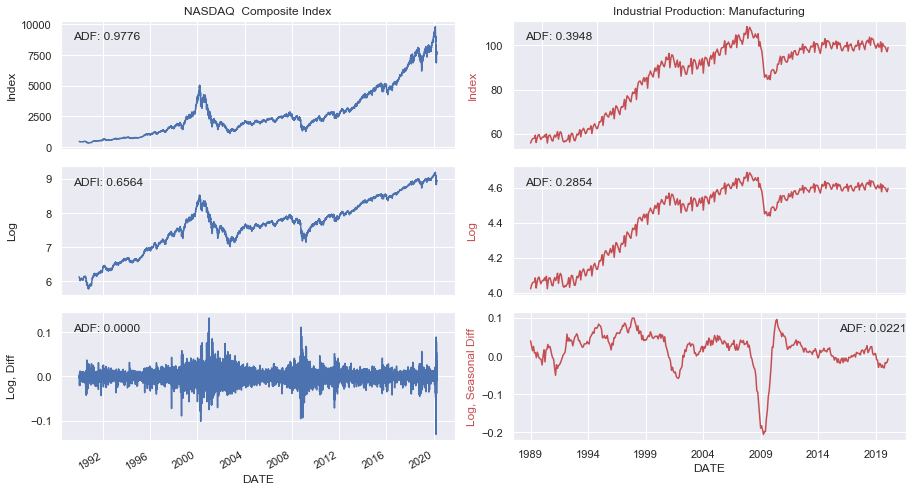

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(13,7))

nasdaq.plot(ax=axes[0][0], title='NASDAQ  Composite Index')
axes[0][0].text(x=.03, y=.85, s=f'ADF: {tsa.adfuller(nasdaq.dropna())[1]:.4f}', transform=axes[0][0].transAxes)
axes[0][0].set_ylabel('Index')

nasdaq_log.plot(ax=axes[1][0], sharex=axes[0][0])
axes[1][0].text(x=.03, y=.85, s=f'ADFl: {tsa.adfuller(nasdaq_log.dropna())[1]:.4f}', transform=axes[1][0].transAxes)
axes[1][0].set_ylabel('Log')

nasdaq_log_diff.plot(ax=axes[2][0], sharex=axes[0][0])
axes[2][0].text(x=.03, y=.85, s=f'ADF: {tsa.adfuller(nasdaq_log_diff.dropna())[1]:.4f}', transform=axes[2][0].transAxes)
axes[2][0].set_ylabel('Log, Diff')

industrial_production.plot(ax=axes[0][1], title='Industrial Production: Manufacturing', color='r')
axes[0][1].text(x=.03, y=.85, s=f'ADF: {tsa.adfuller(industrial_production)[1]:.4f}', transform=axes[0][1].transAxes)
axes[0][1].set_ylabel('Index', color='r')

industrial_production_log.plot(ax=axes[1][1], sharex=axes[0][1], color='r')
axes[1][1].text(x=.03, y=.85, s=f'ADF: {tsa.adfuller(industrial_production_log.dropna())[1]:.4f}', transform=axes[1][1].transAxes)
axes[1][1].set_ylabel('Log', color='r')

industrial_production_log_diff.plot(ax=axes[2][1], sharex=axes[0][1], color='r')
axes[2][1].text(x=.83, y=.85, s=f'ADF: {tsa.adfuller(industrial_production_log_diff.dropna())[1]:.4f}', transform=axes[2][1].transAxes)
axes[2][1].set_ylabel('Log, Seasonal Diff', color='r')
fig.tight_layout()
fig.align_ylabels(axes);